## Importing necessary Libraries.

In [257]:
# Necessary libraries.
from numpy import intersect1d, nan
import pandas as pd
import os
from os.path import join, exists
import re
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

# Helper Functions.

In [212]:
def get_file(filename):
    '''
    Gets the file in list format given the filename.

    Parameters:
        filename -- Path of the file.
        
    Returns:
        list. Contents of WebAnno TSV v3 exported file. Separated by \n.
    '''
    with open(filename, encoding = 'utf-8') as ff:
        text = ff.readlines()
        ff.close()
        return text

def replace_BIO(asp: str, start: bool = True) -> str:
    '''
    If you pass in an aspect category in the form <aspect_category>[anynumber],
    this function will strip the square brakets and 'anynumber'.
    Then, it will add the prefix 'B-' (if it is the beginning of the tag) or
    'I-' (if it lies inside the tag).  
    
    Parameters:
        asp -- str, aspect category in the form <aspect_category>[anynumber].
        start -- Bool, Represents whether the tag is a 'begin' tag.
        
    Returns:
        str. Aspect category in BIO format.
    '''
    
    pattern = r'[\[0-9\]]+'
    asp_bio = re.sub(pattern, '', asp)
    if start:
        asp_bio = 'B-' + asp_bio
    else:
        asp_bio = 'I-' + asp_bio
        
    return asp_bio


def convert_to_bio(highlight: list) -> list:
    '''
    Mapping of keywords and aspects of WebAnno TSVv3 to BIO format.
    
    Parameters:
        highlight -- List of all the highlights in the form <highlight>[anynumber].
        
    Returns:
        List. highlights in BIO format.
    '''
    
    result = ['_']*len(highlight)
    
    for ii, (prev, curr) in enumerate(zip([None]+highlight[:-1], highlight)):
        if curr == '_':
            continue
        else:
            if prev == '_':
                begin = replace_BIO(curr, start = True)
                result[ii] = begin
                
            elif prev != curr and prev != '_':
                begin = replace_BIO(curr, start = True)
                result[ii] = begin
            
            elif prev == curr and prev != '_':
                inside = replace_BIO(curr, start = False)
                result[ii] = inside
                
    return result

def parse_file(filename: str) -> pd.DataFrame:
    """
    Parses a WebAnno TSV v3 file to a DataFrame.
    Preprocessing involved:
        - Converts the aspect category annotations to BIO format.
        - Removes the sentence numbers associated with the annotations in square brackets. e.g. 1[8] --> 1.
        - Removes escape characters like "\".

    Args:
        filename (str): Path to the TSV file.

    Returns:
        pd.DataFrame: DataFrame with columns -- ['s_no, str_id, token, ac, ap, conf, ipv']
    """
    # Getting the exported TSV file.
    text = get_file(filename)
    text = [tt for tt in text if tt != '\n']
    text = text[3:]
    #print(text[:6])

    # Save.
    storage = []
    count = 0    # Sentence counter.
    for ii, line in enumerate(text, 1):
        if line.startswith('#Text'):
            count += 1
            continue
        else:
            splits = line.split()
            if len(splits) == 5:
                splits = splits[:3] + ["_", "_"] + splits[3:]
            storage.append(splits)
   
    # Define DataFrame.
    df = pd.DataFrame(storage, columns = 's_no, str_id, token, ac, ap, conf, ipv'.split(", "))

    # Convert to BIO format.
    df['ac'] = convert_to_bio(df['ac'].to_list())

    # Replace "\\_" with "_" in ac.
    df['ac'] = df['ac'].apply(lambda x: x.replace('\\_', '_'))
    df['ac'] = df['ac'].apply(lambda x: '_' if (x =='B-*') or (x == 'I-*') else x)
    # Fixing aspect polarity.
    df['ap'] = df['ap'].apply(lambda x: x[0] if x != '_' else x)
    df['ap'] = df['ap'].apply(lambda x: '_' if x == '*' else x)

    return df

def merge_annotations(filename_list: list) -> pd.DataFrame:
    """
    Merges the dataframes generated from parse_file function.

    Args:
        filename_list (list): List of filepaths to be parsed.

    Returns:
        pd.DataFrame: DataFrame contaning all the annotations from the files provided.
    """    
    storage = [parse_file(file) for file in filename_list]
    res = pd.concat(storage, axis = 0).reset_index(drop = True)
    return res


# For IPV.

## Source directory.

In [213]:
ipv_root = r'D:\ML_projects\IPV-Project\annotation\data\first_lot\ipv'

## Read files from directory.

In [214]:
shr_root = join(ipv_root, 'Sharmila')
krn_root = join(ipv_root, 'kiran')

shr_files = [file for file in os.listdir(shr_root)]
krn_files = [file for file in os.listdir(krn_root)]

common = intersect1d(shr_files, krn_files)

shr_filenames = [join(shr_root, file) for file in os.listdir(shr_root)]
krn_filenames = [join(krn_root, file) for file in os.listdir(krn_root) if file not in common]

print(f"Number of files in Shr: {len(shr_filenames)}")
print(f"Number of files in Krn: {len(krn_filenames)}")

filenames_ipv = shr_filenames + krn_filenames

Number of files in Shr: 143
Number of files in Krn: 26


## Merge to DataFrame.

In [215]:
df_ipv = merge_annotations(filenames_ipv)

In [216]:
df_ipv.head(20)

,s_no,str_id,token,ac,ap,conf,ipv
0,1-1,0-5,﻿तेरो,_,_,_,_
1,1-2,6-12,अश्लिल,B-general_threat,0,_,_
2,1-3,13-20,फोटोहरू,I-general_threat,0,_,_
3,1-4,21-22,म,_,_,_,_
4,1-5,23-32,सार्वजनिक,B-general_threat,0,_,_
5,1-6,33-42,गरिदिन्छु,_,_,_,_
6,1-7,43-44,।,_,_,6,1
7,2-1,47-51,उसको,_,_,_,_
8,2-2,52-56,नग्न,B-general_threat,0,_,_
9,2-3,57-64,फोटोहरु,I-general_threat,0,_,_


## Basic pre-processing.

### Clean the IPV and conf column.

In [217]:
df_ipv['ipv'] = df_ipv['ipv'].apply(lambda x: x[0] if x != "*" else "_")
df_ipv['ipv'].unique()

array(['_', '1', '0'], dtype=object)

In [218]:
df_ipv['conf'] = df_ipv['conf'].apply(lambda x: x[0] if x != "*" else "_")
df_ipv['conf'].unique()

array(['_', '6', '5', '7', '8', '4', '9', '1', '3'], dtype=object)

### Clean the aspect category column.

In [219]:
df_ipv['ac'] = df_ipv['ac'].replace({"_" : "O"})
df_ipv.ac.unique()

array(['O', 'B-general_threat', 'I-general_threat',
       'B-character_assasination', 'B-profanity',
       'I-character_assasination', 'B-sexism', 'I-sexism',
       'B-physical_threat', 'I-physical_threat', 'I-profanity',
       'B-rape_threat', 'I-rape_threat', 'B-ethnic_violence',
       'I-ethnic_violence', 'B-religion_violence', 'I-religion_violence',
       'B-Others', 'I-Others'], dtype=object)

In [220]:
df_ipv['token'] = df_ipv['token'].replace({'"' : nan})
df_ipv.dropna(inplace = True)

### Add sentence markers.

In [221]:
coll = []
ii = 1
for item in df_ipv['ipv']:
    if item != "_":
        coll.append(coll[-1])
        ii += 1
    else:
        coll.append(f"sentence_{ii}")

In [222]:
df_ipv['sentence_num'] = coll

In [223]:
df_ipv.drop(['s_no', 'str_id'], axis = 1, inplace = True)
df_ipv.head(20)

,token,ac,ap,conf,ipv,sentence_num
0,﻿तेरो,O,_,_,_,sentence_1
1,अश्लिल,B-general_threat,0,_,_,sentence_1
2,फोटोहरू,I-general_threat,0,_,_,sentence_1
3,म,O,_,_,_,sentence_1
4,सार्वजनिक,B-general_threat,0,_,_,sentence_1
5,गरिदिन्छु,O,_,_,_,sentence_1
6,।,O,_,6,1,sentence_1
7,उसको,O,_,_,_,sentence_2
8,नग्न,B-general_threat,0,_,_,sentence_2
9,फोटोहरु,I-general_threat,0,_,_,sentence_2


In [224]:
df_ipv.ap.unique()

array(['_', '0', '1'], dtype=object)

## Group data by sentence numbers.

In [225]:
# Group by sentence numbers.
grouped = df_ipv.groupby("sentence_num")

tokens = grouped.apply(lambda df: [w for w in df['token'].values.tolist()]).to_list()
ac = grouped.apply(lambda df: [w for w in df['ac'].values.tolist()]).to_list()
ap = grouped.apply(lambda df: [w for w in df['ap'].values.tolist()]).to_list()

conf = grouped.apply(lambda df: [w for w in df['conf'].values.tolist()]).to_list()
conf = [item[-1] for item in conf]

is_ipv = grouped.apply(lambda df: [w for w in df['ipv'].values.tolist()]).to_list()
is_ipv = list(map(int, [item[-1] for item in is_ipv]))

In [226]:
len(ac), len(ap), len(tokens), len(is_ipv), len(conf)

(1850, 1850, 1850, 1850, 1850)

## Create new DataFrame for IPV examples.

In [227]:
new_df_ipv = pd.DataFrame({
    'id': range(1, len(is_ipv) + 1),
    'source': 'simulation_ipv',
    'tokens': tokens,
    'ac': ac,
    'ap': ap,
    'conf': conf,
    'ipv': is_ipv
})

## Add text field in the final df.

In [228]:
new_df_ipv['text'] = new_df_ipv['tokens'].apply(lambda x: " ".join(x))
new_df_ipv = new_df_ipv[['id', 'source', 'text', 'tokens', 'ac', 'ap', 'conf', 'ipv']]


In [229]:
new_df_ipv.head(30)

,id,source,text,tokens,ac,ap,conf,ipv
0,1,simulation_ipv,﻿तेरो अश्लिल फोटोहरू म सार्वजनिक गरिदिन्छु ।,"[﻿तेरो, अश्लिल, फोटोहरू, म, सार्वजनिक, गरिदिन्छु, ।]","[O, B-general_threat, I-general_threat, O, B-general_threat, O, O]","[_, 0, 0, _, 0, _, _]",6,1
1,2,simulation_ipv,सम्पत्तिकै लागि बिहे गरेकी रैछ त्यसले ।,"[सम्पत्तिकै, लागि, बिहे, गरेकी, रैछ, त्यसले, ।]","[B-character_assasination, I-character_assasination, I-character_assasination, O, O, O, O]","[0, 0, 0, _, _, _, _]",5,1
2,3,simulation_ipv,चरित्रहिन केटि एस्तो हुन्छ भन्नि तलाई पहिला नै थाहा थिएन र रन्डी |,"[चरित्रहिन, केटि, एस्तो, हुन्छ, भन्नि, तलाई, पहिला, नै, थाहा, थिएन, र, रन्डी, |]","[B-character_assasination, I-character_assasination, O, O, O, O, O, O, O, O, O, B-profanity, O]","[1, 1, _, _, _, _, _, _, _, _, _, 0, _]",7,1
3,4,simulation_ipv,"तँ साला भालु , बिग्रेकी आइमाई। ।","[तँ, साला, भालु, ,, बिग्रेकी, आइमाई।, ।]","[O, B-profanity, I-profanity, O, B-profanity, I-profanity, O]","[_, 0, 0, _, 0, 0, _]",5,1
4,5,simulation_ipv,"तँ साला भालु , बिग्रेकी आइमाई। ।","[तँ, साला, भालु, ,, बिग्रेकी, आइमाई।, ।]","[O, B-profanity, I-profanity, O, B-profanity, I-profanity, O]","[_, 0, 0, _, 0, 0, _]",5,1
5,6,simulation_ipv,कसैले नजानेको तैंले जानेकी रहिछेस जाबो केहि पैसाको लोभमा अरुलाई गाली गर्दै हिड्ने तँ जस्तो गतिछाडा आइमाई को के कुरा सुन्नु |,"[कसैले, नजानेको, तैंले, जानेकी, रहिछेस, जाबो, केहि, पैसाको, लोभमा, अरुलाई, गाली, गर्दै, हिड्ने, तँ, जस्तो, गतिछाडा, आइमाई, को, के, कुरा, सुन्नु, |]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-character_assasination, I-character_assasination, O, O, O, O, O]","[_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, 0, 0, _, _, _, _, _]",5,1
6,7,simulation_ipv,"तैंले मेरो जिन्दगि बर्बाद गर्दिस , कामना गर्छु तैंले सफलता कहिले नपावोस। राछेस्नी , रन्डी ।","[तैंले, मेरो, जिन्दगि, बर्बाद, गर्दिस, ,, कामना, गर्छु, तैंले, सफलता, कहिले, नपावोस।, राछेस्नी, ,, रन्डी, ।]","[O, O, O, O, O, O, O, O, O, B-profanity, I-profanity, I-profanity, B-profanity, I-profanity, I-profanity, O]","[_, _, _, _, _, _, _, _, _, 0, 0, 0, 0, 0, 0, _]",6,1
7,8,simulation_ipv,"खाते साला तैंले मेरो मन धेरै नै दुखाको छस् , म तँलाई धेरै नै यातना दिने छु। ।","[खाते, साला, तैंले, मेरो, मन, धेरै, नै, दुखाको, छस्, ,, म, तँलाई, धेरै, नै, यातना, दिने, छु।, ।]","[B-profanity, I-profanity, O, O, O, O, O, O, O, O, O, O, O, O, B-general_threat, I-general_threat, I-general_threat, O]","[0, 0, _, _, _, _, _, _, _, _, _, _, _, _, 1, 1, 1, _]",6,1
8,9,simulation_ipv,तँ र तेरो परिवारलाई म बिस्तारै मार्दै जान्छु। ।,"[तँ, र, तेरो, परिवारलाई, म, बिस्तारै, मार्दै, जान्छु।, ।]","[O, O, O, O, O, O, B-physical_threat, I-physical_threat, O]","[_, _, _, _, _, _, 1, 1, _]",5,1
9,10,simulation_ipv,तँ र तेरो परिवारलाई मार्ने योजना मैले पहिला देखिनै बनाउदै आएको छु। ।,"[तँ, र, तेरो, परिवारलाई, मार्ने, योजना, मैले, पहिला, देखिनै, बनाउदै, आएको, छु।, ।]","[O, O, O, O, B-general_threat, I-general_threat, O, O, O, O, O, O, O]","[_, _, _, _, 1, 1, _, _, _, _, _, _, _]",4,1


# For non-IPV.

In [230]:
## Source directory.
non_ipv_root = r'D:\ML_projects\IPV-Project\annotation\data\first_lot\non-ipv'

## Read files from directory.
shr_root = join(non_ipv_root, 'shr')
krn_root = join(non_ipv_root, 'krn')

shr_files = [file for file in os.listdir(shr_root)]
krn_files = [file for file in os.listdir(krn_root)]

common = intersect1d(shr_files, krn_files)

shr_filenames = [join(shr_root, file) for file in os.listdir(shr_root)]
krn_filenames = [join(krn_root, file) for file in os.listdir(krn_root) if file not in common]

print(f"Number of files in Shr: {len(shr_filenames)}")
print(f"Number of files in Krn: {len(krn_filenames)}")

filenames_non_ipv = shr_filenames + krn_filenames

Number of files in Shr: 100
Number of files in Krn: 50


In [231]:
common

array(['batch_non_ipv_0-10.tsv', 'batch_non_ipv_10-20.tsv',
       'batch_non_ipv_120-130.tsv', 'batch_non_ipv_140-150.tsv',
       'batch_non_ipv_150-160.tsv', 'batch_non_ipv_160-170.tsv',
       'batch_non_ipv_170-180.tsv', 'batch_non_ipv_180-190.tsv',
       'batch_non_ipv_190-200.tsv', 'batch_non_ipv_20-30.tsv',
       'batch_non_ipv_200-210.tsv', 'batch_non_ipv_210-220.tsv',
       'batch_non_ipv_220-230.tsv', 'batch_non_ipv_230-240.tsv',
       'batch_non_ipv_240-250.tsv', 'batch_non_ipv_250-260.tsv',
       'batch_non_ipv_260-270.tsv', 'batch_non_ipv_270-280.tsv',
       'batch_non_ipv_280-290.tsv', 'batch_non_ipv_290-300.tsv',
       'batch_non_ipv_30-40.tsv', 'batch_non_ipv_40-50.tsv',
       'batch_non_ipv_410-420.tsv', 'batch_non_ipv_50-60.tsv',
       'batch_non_ipv_60-70.tsv', 'batch_non_ipv_70-80.tsv',
       'batch_non_ipv_80-90.tsv', 'batch_non_ipv_90-100.tsv'],
      dtype='<U27')

In [232]:
## Merge to DataFrame.
df_non_ipv = merge_annotations(filenames_non_ipv)
df_non_ipv.head(20)


,s_no,str_id,token,ac,ap,conf,ipv
0,1-1,0-4,तिमी,_,_,_,_
1,1-2,5-8,कति,_,_,_,_
2,1-3,9-15,राम्री,_,_,_,_
3,1-4,16-18,छौ,_,_,_,_
4,1-5,19-20,|,_,_,9,0
5,1-6,21-22,म,_,_,_,_
6,1-7,23-30,तिमीलाई,_,_,_,_
7,1-8,31-35,माया,_,_,_,_
8,1-9,36-41,गर्छु,_,_,_,_
9,1-10,42-43,|,_,_,9,0


In [233]:
## Basic pre-processing.

### Clean the IPV and conf column.
df_non_ipv['ipv'] = df_non_ipv['ipv'].apply(lambda x: x[0] if x != "*" else "_")
df_non_ipv['ipv'].unique()
df_non_ipv['conf'] = df_non_ipv['conf'].apply(lambda x: x[0] if x != "*" else "_")
df_non_ipv['conf'].unique()

### Clean the aspect category column.
df_non_ipv['ac'] = df_non_ipv['ac'].replace({"_" : "O"})
df_non_ipv.ac.unique()
df_non_ipv['token'] = df_non_ipv['token'].replace({'"' : nan})
df_non_ipv.dropna(inplace = True)


In [234]:
df_non_ipv.head(30)

,s_no,str_id,token,ac,ap,conf,ipv
0,1-1,0-4,तिमी,O,_,_,_
1,1-2,5-8,कति,O,_,_,_
2,1-3,9-15,राम्री,O,_,_,_
3,1-4,16-18,छौ,O,_,_,_
4,1-5,19-20,|,O,_,9,0
5,1-6,21-22,म,O,_,_,_
6,1-7,23-30,तिमीलाई,O,_,_,_
7,1-8,31-35,माया,O,_,_,_
8,1-9,36-41,गर्छु,O,_,_,_
9,1-10,42-43,|,O,_,9,0


In [235]:
### Add sentence markers.
coll = []
ii = 1
for item in df_non_ipv['ipv']:
    if item != "_":
        coll.append(coll[-1])
        ii += 1
    else:
        coll.append(f"sentence_{ii}")
        
df_non_ipv['sentence_num'] = coll
df_non_ipv.drop(['s_no', 'str_id'], axis = 1, inplace = True)
df_non_ipv.head(20)


,token,ac,ap,conf,ipv,sentence_num
0,तिमी,O,_,_,_,sentence_1
1,कति,O,_,_,_,sentence_1
2,राम्री,O,_,_,_,sentence_1
3,छौ,O,_,_,_,sentence_1
4,|,O,_,9,0,sentence_1
5,म,O,_,_,_,sentence_2
6,तिमीलाई,O,_,_,_,sentence_2
7,माया,O,_,_,_,sentence_2
8,गर्छु,O,_,_,_,sentence_2
9,|,O,_,9,0,sentence_2


In [236]:
# Group by sentence numbers.
grouped = df_non_ipv.groupby("sentence_num")

tokens = grouped.apply(lambda df: [w for w in df['token'].values.tolist()]).to_list()
ac = grouped.apply(lambda df: [w for w in df['ac'].values.tolist()]).to_list()
ap = grouped.apply(lambda df: [w for w in df['ap'].values.tolist()]).to_list()

conf = grouped.apply(lambda df: [w for w in df['conf'].values.tolist()]).to_list()
conf = [item[-1] for item in conf]

is_ipv = grouped.apply(lambda df: [w for w in df['ipv'].values.tolist()]).to_list()
is_ipv = list(map(int, [item[-1] for item in is_ipv]))

In [237]:
## Create new DataFrame for non-IPV examples.
new_df_non_ipv = pd.DataFrame({
    'id': range(1, len(is_ipv) + 1),
    'source': 'simulation_non_ipv',
    'tokens': tokens,
    'ac': ac,
    'ap': ap,
    'conf': conf,
    'ipv': is_ipv
})
new_df_non_ipv['text'] = new_df_non_ipv['tokens'].apply(lambda x: " ".join(x))
new_df_non_ipv = new_df_non_ipv[['id', 'source', 'text', 'tokens', 'ac', 'ap', 'conf', 'ipv']]
new_df_non_ipv.head(30)

,id,source,text,tokens,ac,ap,conf,ipv
0,1,simulation_non_ipv,तिमी कति राम्री छौ |,"[तिमी, कति, राम्री, छौ, |]","[O, O, O, O, O]","[_, _, _, _, _]",9,0
1,2,simulation_non_ipv,सानु तिमी र म भेटम न ल |,"[सानु, तिमी, र, म, भेटम, न, ल, |]","[O, O, O, O, O, O, O, O]","[_, _, _, _, _, _, _, _]",9,0
2,3,simulation_non_ipv,हामी नेपाली हरुलाइ यस्तो ज्यान मारा नेपाल प्रहरी चाहिदैन जन्तालाइ सुरक्षा दिने प्रहरी चाहिए को छ ।,"[हामी, नेपाली, हरुलाइ, यस्तो, ज्यान, मारा, नेपाल, प्रहरी, चाहिदैन, जन्तालाइ, सुरक्षा, दिने, प्रहरी, चाहिए, को, छ, ।]","[O, O, O, O, B-profanity, I-profanity, O, O, O, O, O, O, O, O, O, O, O]","[_, _, _, _, 1, 1, _, _, _, _, _, _, _, _, _, _, _]",1,0
3,4,simulation_non_ipv,जे गर्छौ गर नटकै र नौटङकि गर एत्रा डर |,"[जे, गर्छौ, गर, नटकै, र, नौटङकि, गर, एत्रा, डर, |]","[O, O, O, B-profanity, I-profanity, I-profanity, O, O, O, O]","[_, _, _, 0, 0, 0, _, _, _, _]",6,0
4,5,simulation_non_ipv,गजब |,"[गजब, |]","[O, O]","[_, _]",1,0
5,6,simulation_non_ipv,हेरुम्न तिम्रो चट्पटे भन्दा सस्तो पर्ने प्रचारप्रसार लाई |,"[हेरुम्न, तिम्रो, चट्पटे, भन्दा, सस्तो, पर्ने, प्रचारप्रसार, लाई, |]","[O, O, B-profanity, I-profanity, I-profanity, O, O, O, O]","[_, _, 0, 0, 0, _, _, _, _]",1,0
6,7,simulation_non_ipv,सरर होइन यार सुलुलुलु हों |,"[सरर, होइन, यार, सुलुलुलु, हों, |]","[O, O, O, O, O, O]","[_, _, _, _, _, _]",1,0
7,8,simulation_non_ipv,चुना सम्म हाेला |,"[चुना, सम्म, हाेला, |]","[O, O, O, O]","[_, _, _, _]",1,0
8,9,simulation_non_ipv,म तिमीलाई माया गर्दिन |,"[म, तिमीलाई, माया, गर्दिन, |]","[O, O, O, O, O]","[_, _, _, _, _]",9,0
9,10,simulation_non_ipv,म तिमीलाई कहिले भुल्न सक्दिन |,"[म, तिमीलाई, कहिले, भुल्न, सक्दिन, |]","[O, O, O, O, O, O]","[_, _, _, _, _, _]",9,0


# For Twitter data.

In [238]:
twt_root = r'D:\ML_projects\IPV-Scraper\results'
twt_filename = 'scraped_tweets_cleaned_22-04-022.csv'

df_twt = pd.read_csv(join(twt_root, twt_filename), encoding = 'utf-8')
df_twt.head(10)
print(f'Shape before: {df_twt.shape}')

# Remove NA and duplicates.
df_twt.dropna(inplace = True)
df_twt.drop_duplicates(inplace = True)

print(f'Shape after: {df_twt.shape}')

Shape before: (1418, 4)
Shape after: (1418, 4)


## Add ID and Source columns.

In [287]:
df_twt['id'] = range(1, len(df_twt) + 1)
df_twt['source'] = ['twitter'] * len(df_twt)
df_twt = df_twt.rename(columns={'tweet': 'text'})

In [288]:
df_twt.tail()

,date,text,link,keyword,id,source
1413,2018-01-23 10:54:25,धेरै ताती सकिस यादगर एकदिन आफै सितल हुन्छेस सुन बुढो खोज्दै हिड्छेस एकदिन आफै पितल हुन्छेस,https://twitter.com/tOr7AvpntQeXeQP/status/955668770609037313,हिड्छेस,1414,twitter
1414,2018-01-19 22:30:41,त पोके त होस रौसी खादै हिड्छेस,https://twitter.com/omkarpdl/status/954394440889593857,हिड्छेस,1415,twitter
1415,2017-12-26 20:34:45,घरमा माया गर्ने आफ्ना आमा बाबू हुदा हुँदै अर्काको छोरालाइ माया गर्दै हिड्छेस त धोका नपाए के iphone पाउछेस त।,https://twitter.com/ayush_kan/status/945667956863676416,हिड्छेस,1416,twitter
1416,2017-12-22 19:29:59,"अध्यारोमा हिडिरहदा-छाया लाई सोध्न मन लाग्छ। ओई त म संग किन हिड्छेस यस्ले नि सजिलै उत्तर देला, तँ संग हिड्ने अरु को नै छ र!",https://twitter.com/UjyaaloPradip/status/944202108181520385,हिड्छेस,1417,twitter
1417,2017-10-12 00:30:05,मेरो बुढासंग सुतेर हिड्छेस भन्दै दुइ महिला बाटो बाटो झगडा गरे पछी भिडीयो सहित.,https://twitter.com/sajhapage/status/918185701757280256,हिड्छेस,1418,twitter


# All data.

In [289]:
df = pd.concat([new_df_ipv, new_df_non_ipv, df_twt], axis = 0, ignore_index = True)

# Reset ID column.
df['id'] = range(1, len(df) + 1)

In [290]:
df.head(40)

,id,source,text,tokens,ac,ap,conf,ipv,date,link,keyword
0,1,simulation_ipv,﻿तेरो अश्लिल फोटोहरू म सार्वजनिक गरिदिन्छु ।,"[﻿तेरो, अश्लिल, फोटोहरू, म, सार्वजनिक, गरिदिन्छु, ।]","[O, B-general_threat, I-general_threat, O, B-general_threat, O, O]","[_, 0, 0, _, 0, _, _]",6,1.0,NaN,NaN,NaN
1,2,simulation_ipv,सम्पत्तिकै लागि बिहे गरेकी रैछ त्यसले ।,"[सम्पत्तिकै, लागि, बिहे, गरेकी, रैछ, त्यसले, ।]","[B-character_assasination, I-character_assasination, I-character_assasination, O, O, O, O]","[0, 0, 0, _, _, _, _]",5,1.0,NaN,NaN,NaN
2,3,simulation_ipv,चरित्रहिन केटि एस्तो हुन्छ भन्नि तलाई पहिला नै थाहा थिएन र रन्डी |,"[चरित्रहिन, केटि, एस्तो, हुन्छ, भन्नि, तलाई, पहिला, नै, थाहा, थिएन, र, रन्डी, |]","[B-character_assasination, I-character_assasination, O, O, O, O, O, O, O, O, O, B-profanity, O]","[1, 1, _, _, _, _, _, _, _, _, _, 0, _]",7,1.0,NaN,NaN,NaN
3,4,simulation_ipv,"तँ साला भालु , बिग्रेकी आइमाई। ।","[तँ, साला, भालु, ,, बिग्रेकी, आइमाई।, ।]","[O, B-profanity, I-profanity, O, B-profanity, I-profanity, O]","[_, 0, 0, _, 0, 0, _]",5,1.0,NaN,NaN,NaN
4,5,simulation_ipv,"तँ साला भालु , बिग्रेकी आइमाई। ।","[तँ, साला, भालु, ,, बिग्रेकी, आइमाई।, ।]","[O, B-profanity, I-profanity, O, B-profanity, I-profanity, O]","[_, 0, 0, _, 0, 0, _]",5,1.0,NaN,NaN,NaN
5,6,simulation_ipv,कसैले नजानेको तैंले जानेकी रहिछेस जाबो केहि पैसाको लोभमा अरुलाई गाली गर्दै हिड्ने तँ जस्तो गतिछाडा आइमाई को के कुरा सुन्नु |,"[कसैले, नजानेको, तैंले, जानेकी, रहिछेस, जाबो, केहि, पैसाको, लोभमा, अरुलाई, गाली, गर्दै, हिड्ने, तँ, जस्तो, गतिछाडा, आइमाई, को, के, कुरा, सुन्नु, |]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-character_assasination, I-character_assasination, O, O, O, O, O]","[_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, 0, 0, _, _, _, _, _]",5,1.0,NaN,NaN,NaN
6,7,simulation_ipv,"तैंले मेरो जिन्दगि बर्बाद गर्दिस , कामना गर्छु तैंले सफलता कहिले नपावोस। राछेस्नी , रन्डी ।","[तैंले, मेरो, जिन्दगि, बर्बाद, गर्दिस, ,, कामना, गर्छु, तैंले, सफलता, कहिले, नपावोस।, राछेस्नी, ,, रन्डी, ।]","[O, O, O, O, O, O, O, O, O, B-profanity, I-profanity, I-profanity, B-profanity, I-profanity, I-profanity, O]","[_, _, _, _, _, _, _, _, _, 0, 0, 0, 0, 0, 0, _]",6,1.0,NaN,NaN,NaN
7,8,simulation_ipv,"खाते साला तैंले मेरो मन धेरै नै दुखाको छस् , म तँलाई धेरै नै यातना दिने छु। ।","[खाते, साला, तैंले, मेरो, मन, धेरै, नै, दुखाको, छस्, ,, म, तँलाई, धेरै, नै, यातना, दिने, छु।, ।]","[B-profanity, I-profanity, O, O, O, O, O, O, O, O, O, O, O, O, B-general_threat, I-general_threat, I-general_threat, O]","[0, 0, _, _, _, _, _, _, _, _, _, _, _, _, 1, 1, 1, _]",6,1.0,NaN,NaN,NaN
8,9,simulation_ipv,तँ र तेरो परिवारलाई म बिस्तारै मार्दै जान्छु। ।,"[तँ, र, तेरो, परिवारलाई, म, बिस्तारै, मार्दै, जान्छु।, ।]","[O, O, O, O, O, O, B-physical_threat, I-physical_threat, O]","[_, _, _, _, _, _, 1, 1, _]",5,1.0,NaN,NaN,NaN
9,10,simulation_ipv,तँ र तेरो परिवारलाई मार्ने योजना मैले पहिला देखिनै बनाउदै आएको छु। ।,"[तँ, र, तेरो, परिवारलाई, मार्ने, योजना, मैले, पहिला, देखिनै, बनाउदै, आएको, छु।, ।]","[O, O, O, O, B-general_threat, I-general_threat, O, O, O, O, O, O, O]","[_, _, _, _, 1, 1, _, _, _, _, _, _, _]",4,1.0,NaN,NaN,NaN


In [243]:
df['source'].unique()

array(['simulation_ipv', 'simulation_non_ipv', 'twitter'], dtype=object)

### Save to excel File.

In [291]:
df.to_excel(join(r'D:\ML_projects\IPV-Project\annotation\data', 'overall.xlsx'), encoding = 'utf-8', index = None)

# Analysis.

In [251]:
df.source.value_counts()

simulation_ipv        1850
simulation_non_ipv    1638
twitter               1418
Name: source, dtype: int64

In [286]:
df.source.value_counts().sum()

4906

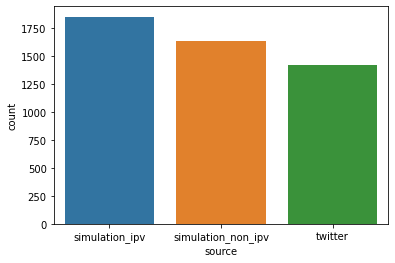

In [259]:
sns.countplot(df.source)
plt.savefig('source.png')
plt.show()

### Count aspect categories.

In [260]:
ac = df['ac'].dropna()
ac

0       [O, B-general_threat, I-general_threat, O, B-general_threat, O, O]                             
1       [B-character_assasination, I-character_assasination, I-character_assasination, O, O, O, O]     
2       [B-character_assasination, I-character_assasination, O, O, O, O, O, O, O, O, O, B-profanity, O]
3       [O, B-profanity, I-profanity, O, B-profanity, I-profanity, O]                                  
4       [O, B-profanity, I-profanity, O, B-profanity, I-profanity, O]                                  
                                    ...                                                                
3483    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]                                                  
3484    [O, O, O, O, O, O, O, O, O, O, B-profanity, O, O]                                              
3485    [O, B-profanity, I-profanity, O, O]                                                            
3486    [O, O, O, O, O, O]                                      

In [277]:
from collections import Counter
temp = ac.sum()
temp = [ff[2:] for ff in temp if temp != "O"]

counts = Counter(temp)
counts

Counter({'': 30662,
         'general_threat': 1998,
         'character_assasination': 2207,
         'profanity': 5636,
         'physical_threat': 1817,
         'rape_threat': 109,
         'sexism': 201,
         'ethnic_violence': 186,
         'Others': 36,
         'religion_violence': 81})

In [282]:
x = pd.DataFrame(counts, index = range(len(counts)))
x = x.iloc[0, :].T
x

                          30662
general_threat            1998 
character_assasination    2207 
profanity                 5636 
physical_threat           1817 
rape_threat               109  
sexism                    201  
ethnic_violence           186  
Others                    36   
religion_violence         81   
Name: 0, dtype: int64

In [294]:
x = x.nlargest(9)

In [295]:
x.to_excel('ac.xlsx')